In [1]:
import numpy as np 
import pandas as pd 
from itertools import tee
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, RFE
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA

## Carregamento dos dados

A utilização de métodos tradicionais de ML acarreta o inconveniente de apenas podermos treinar o modelo com um dataset. No caso do covid-19 e deste dataset, por se tratarem de séries temporais não podemos concatenar os dados de diferentes países para termos um maior volume de linhas para treino, o que no impede de utilizar o dataset global. Daí usarmos apenas o de Portugal para prever os seu novos casos confirmados e novas mortes.

In [2]:
dataset = pd.read_csv("../input/aa2-covid-19-parte-i/modified_dataset.csv")
dataset = dataset.drop(['Unnamed: 0'], axis = 1)

In [3]:
# funções auxiliares

def data_split(data, target):
    y = data[target]
    x = data.drop([target], axis=1)
    
    return x, y

def split_for_model(data, train_count):
    train = data[:train_count] 
    test = data[train_count:]
    
    return train, test
    

def plot_prediction(data, prediction, y_train, target, train_size):
    aux_train = y_train.copy()
    combined = pd.concat([aux_train, pd.Series(prediction, index=list(range(train_size, data.shape[0])))])
    final = pd.concat([combined, data[target]], keys = ['previsão', 'real'], axis=1)
    final = final.tail(data.shape[0]- train_size + 5)
    ax = final.plot(figsize=(15,5))
    ax = plt.axvline(x=train_size-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    
    
def barplot_prediction(prediction, y_test):
    r = pd.DataFrame({'Real': y_test, 'Predicted': prediction.flatten()})
    r.plot(kind='bar',figsize=(20,5), title='Predictions')
    plt.show()

# Tradicional ML

Como os dados são muito poucos vamos apenas assumir que os dados de teste são apenas correspondentes aos últimos 7 dias presentes na série temporal.

In [4]:
test_size = 7
train_size = dataset.shape[0] - test_size

Outra limitação de técnias tradicionais é que se queremos prever várias variáveis, ou seja, ter vários outputs temos de ter modelos diferentes para cada previsão, por isso a partir de agora teremos dois datasets, que vão ser treinados de forma separada, gerando modelos distintos. Para isso temos as seguintes linhas que criam esses novos datasets, separando já as features da variável alvo.

In [5]:
x_confirmados, y_confirmados = data_split(dataset, 'confirmados_novos')
x_obitos, y_obitos = data_split(dataset, 'obitos_novos')

## Normalização

Irá ser efetuada normalização para permitir a melhor convergência nos modelos que iremos construir.

In [6]:
scaler_confirmados = MinMaxScaler()
scaler_obitos = MinMaxScaler()

x_confirmados = scaler_confirmados.fit_transform(x_confirmados)
x_obitos = scaler_obitos.fit_transform(x_obitos)

## Separação do Dataset em Treino e Teste

In [7]:
x_train_c, x_test_c = split_for_model(x_confirmados, train_size)
x_train_o, x_test_o = split_for_model(x_obitos, train_size)

y_train_c, y_test_c = split_for_model(y_confirmados, train_size)
y_train_o, y_test_o = split_for_model(y_obitos, train_size)

## Construção dos modelos lineares e polinomias

Na construção de cada modelo vamos ter de ter em conta o grande número de atributos presentes de momento no dataset. Para este efeito, por agora iremos utilizar modelos com regularização (Ridge e Lasso), onde a seleção de atributos está imbutida no modelo, e ainda modelos simples onde iremos utilizar RFECV e RFE (wrappers) para a seleção de atributos.

Note-se que iremos utilizar modelos polinomiais, mas apenas de grau 2 em todos os atributos, porque não valerá a pena ser muito extenso neste sentido.

No que toca a cross validation iremos utilizar o método TimeSeriesSplit para que consigamos avaliar corretamente as séries temporarais. Daqui em diante iremos usar sempre a mesma métrica de scoring, o RMSE, para conseguirmos comparar diferentes modelos.

In [8]:
# Define os modelos simples. Apenas o linear, neste caso.
def calculate_simple_models():
    ols = linear_model.LinearRegression(normalize=False)
    return {'OLS': ols}


# Retira os scores dos modelos simples. Utiliza RFECV para a seleção de atributos.
def get_scores_simple_models(e, x_train, y_train, x_test, y_test, dataset):
    tss = TimeSeriesSplit(n_splits=5).split(x_train)
    
    selector = RFECV(estimator=e, step=1, cv=tss, scoring='neg_root_mean_squared_error')
    selector.fit(x_train, y_train)
    
    x_train_reduced = selector.transform(x_train)
    x_test_reduced = selector.transform(x_test)
    
    print('Selected: ' + str(selector.n_features_) + ' features from model: ' + str(selector.estimator_))
    for i in range(x_train.shape[1]):
        if selector.support_[i] == True:
            print('Column: %s' % (dataset.columns[i]))
            
    return get_scores(selector.estimator_, x_train_reduced, y_train, x_test_reduced, y_test)

# A partir de cross validation obtem os scores no treino e na validação do modelo. Utiliza o predict para obter o score de teste
def get_scores(estimator, x_train, y_train, x_test, y_test):
    tss = TimeSeriesSplit(n_splits=5).split(x_train)
    score = cross_validate(estimator, x_train, y_train, cv=tss,
                           scoring= 'neg_root_mean_squared_error', 
                           return_train_score=True)
    
    
    train_rmse = (score['train_score']*-1).mean()
    validation_rmse = (score['test_score']*-1).mean()
    
    prediction = estimator.predict(x_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, prediction))
    
    return [train_rmse, validation_rmse, test_rmse]

In [9]:
# Define modelos que contém regularização e, portanto, utiliza gridSearch para otimizar os hiperparámetros
def calculate_models_with_regularization(x_train, y_train):
    tss_a = TimeSeriesSplit(n_splits=5).split(x_train)
    tss_b, tss_c = tee(tss_a)
    tss1, tss2 = tee(tss_b)
    tss3, tss4 = tee(tss_c)

    lasso_params = {'alpha':[100, 10, 1, 0.5, 0.1, 0.01]}
    ridge_params = {'alpha':[100, 10, 1, 0.5, 0.1, 0.01]}

    lasso_params_poly = {'fit__alpha':[100, 10, 1, 0.1, 0.01]}
    ridge_params_poly = {'fit__alpha':[100, 10, 1, 0.1, 0.01]}
    
    lasso = linear_model.Lasso(normalize=False, max_iter=1000000000)
    ridge = linear_model.Ridge(normalize=False, max_iter=1000000000)
    
    pipe1 = Pipeline([('poly', PolynomialFeatures()),
                     ('fit', lasso)])
    pipe2 = Pipeline([('poly', PolynomialFeatures()),
                     ('fit', ridge)])

    models = {'Lasso': GridSearchCV(lasso, param_grid=lasso_params, cv=tss1, scoring='neg_root_mean_squared_error',return_train_score=True, refit=True).fit(x_train, y_train),
              'Ridge': GridSearchCV(ridge, param_grid=ridge_params, cv=tss2, scoring='neg_root_mean_squared_error',return_train_score=True, refit=True).fit(x_train, y_train),
              'LassoPoly': GridSearchCV(pipe1, param_grid=lasso_params_poly, cv=tss3, scoring='neg_root_mean_squared_error',return_train_score=True,refit=True).fit(x_train, y_train),
              'RidgePoly': GridSearchCV(pipe2, param_grid=ridge_params_poly, cv=tss4, scoring='neg_root_mean_squared_error',return_train_score=True,refit=True).fit(x_train, y_train),}
    
    return models

# A obtem os scores de um modelo associado a gridSearch e os scores inerentes ao teste 
def get_scores_models_with_regularization(models, x_test, y_test):
    
    rmse_train_svm = models.cv_results_['mean_train_score'][models.best_index_] * -1
    rmse_val_svm = models.best_score_*-1

    train_rmse = rmse_train_svm
    validation_rmse = rmse_val_svm

    estimator = models.best_estimator_
    y_pred = estimator.predict(x_test) 

    test_rmse = np.sqrt(mean_squared_error(y_test,y_pred))    
    
    return [train_rmse, validation_rmse, test_rmse]

### Definição, treino e validação dos modelos para os novos casos confirmados

In [10]:
simple_models_c = calculate_simple_models()
models_with_regularization_c = calculate_models_with_regularization(x_train_c, y_train_c)

In [11]:
regularization_scores_c = dict(map(lambda x: (x[0], get_scores_models_with_regularization(x[1], x_test_c, y_test_c)), models_with_regularization_c.items()))

In [12]:
aux_dataset_c, y = data_split(dataset, 'confirmados_novos')
simple_scores_c = dict(map(lambda x: (x[0], get_scores_simple_models(x[1], x_train_c, y_train_c, x_test_c, y_test_c, aux_dataset_c)), simple_models_c.items()))

Selected: 2 features from model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Column: suspeitos_novos
Column: confirmados_novos_trend_31


No print anterior podemos os atributos selecionados pelo RFECV para o caso da regressão linear e podemos ver que de facto muitos deles foram cálculados previamente, como é o caso de lags e trends. Algo que é interessante é que para o cálculo dos casos confirmados o modelo está a utilizar tanto as tendências a partir de 15 dias dos novos casos confirmados, como as dos novos óbitos, que é o mais interessante, visto que significa que o modelo está a usar as mortes para prever os casos. 

Também podemos confirmar que, entre outros atributos, os sujeitos que aguardam resultados (lab), novos supeitos e em vigilância foram mantidos pelo RFECV no modelo o que vai de encontro ao que é esperado, visto que faz sentido que estes atributos influenciem os casos confirmados, porque estes são um subconjunto deles.

Como os restante modelos contém a seleção imbutida no modelo torna-se difícil analisar os atributos relevantes desses modelos, mas podemos tentar analisar os coeficientes dos modelos. Para não sermos muito extensos vamos olhar apenas para os modelos Lasso e Ridge, sem utilizar funções polinomias, visto que os coeficientes destas são impraticáveis de olhar.

Para o Lasso é fácil de saber quais os atributos relevantes, porque o seu coeficiente vai ser diferente de 0, devido à regularização L1. Para o ridge será mais complicado, porque ele atribui valor a todos os atributos. Posto isto vamos verificar apenas o top 20 de atributos em valor absoluto dos seus coeficientes para a análise.

In [13]:
def get_sorted(x,y):
    result = zip(x,y)
    result= list(map(lambda p : (p[0],abs(p[1])), result))
    return sorted(result, key= lambda x: x[1], reverse=True)

In [14]:
ridge_coefs = models_with_regularization_c['Ridge'].best_estimator_.coef_
x = [aux_dataset_c.columns[i] for i in list(range(len(ridge_coefs)))]
for i in get_sorted(x,ridge_coefs)[:20]:
    print("Atributo: " + i[0] + ", ", "coef: " + str(i[1]))

Atributo: obitos_novos_trend_24,  coef: 293.26113465133466
Atributo: confirmados_novos_trend_31,  coef: 289.48498706368383
Atributo: suspeitos_novos,  coef: 244.5449022100306
Atributo: suspeitos_novos_lag_1,  coef: 213.43404575203652
Atributo: obitos_novos_trend_19,  coef: 191.1233099391361
Atributo: obitos_novos_trend_30,  coef: 161.19292166133764
Atributo: confirmados_novos_trend_21,  coef: 159.03392322800724
Atributo: confirmados_novos_lag_6,  coef: 155.74451305465433
Atributo: obitos_novos_lag_7,  coef: 152.7095353834204
Atributo: obitos_novos_trend_26,  coef: 139.15261734310437
Atributo: vigilancia,  coef: 137.15258609087107
Atributo: confirmados_novos_trend_19,  coef: 131.1282217880331
Atributo: suspeitos_novos_lag_4,  coef: 128.75780791233123
Atributo: obitos_novos_trend_21,  coef: 128.2372463306462
Atributo: confirmados_novos_trend_26,  coef: 127.171649857012
Atributo: confirmados_novos_lag_1,  coef: 125.61546315625417
Atributo: suspeitos_novos_lag_3,  coef: 112.40282586724452


In [15]:
ridge_coefs = models_with_regularization_c['Ridge'].best_estimator_.coef_
x = [aux_dataset_c.columns[i] for i in list(range(len(ridge_coefs)))]
for i in get_sorted(x,ridge_coefs)[:20]:
    print("Atributo: " + i[0] + ", ", "coef: " + str(i[1]))

Atributo: obitos_novos_trend_24,  coef: 293.26113465133466
Atributo: confirmados_novos_trend_31,  coef: 289.48498706368383
Atributo: suspeitos_novos,  coef: 244.5449022100306
Atributo: suspeitos_novos_lag_1,  coef: 213.43404575203652
Atributo: obitos_novos_trend_19,  coef: 191.1233099391361
Atributo: obitos_novos_trend_30,  coef: 161.19292166133764
Atributo: confirmados_novos_trend_21,  coef: 159.03392322800724
Atributo: confirmados_novos_lag_6,  coef: 155.74451305465433
Atributo: obitos_novos_lag_7,  coef: 152.7095353834204
Atributo: obitos_novos_trend_26,  coef: 139.15261734310437
Atributo: vigilancia,  coef: 137.15258609087107
Atributo: confirmados_novos_trend_19,  coef: 131.1282217880331
Atributo: suspeitos_novos_lag_4,  coef: 128.75780791233123
Atributo: obitos_novos_trend_21,  coef: 128.2372463306462
Atributo: confirmados_novos_trend_26,  coef: 127.171649857012
Atributo: confirmados_novos_lag_1,  coef: 125.61546315625417
Atributo: suspeitos_novos_lag_3,  coef: 112.40282586724452


Podemos observar através dos top 20 do Ridge e do Lasso que os atributos selecionados são os mesmos, o que faz sentido, visto que o modelo é o mesmo e eles não se desviam muito dos selecionados pelo RFECV no caso do linear, porém os modelos irão ser um pouco diferentes em termos de resultados, como veremos de seguida.

Temos agora os scores(RMSE) apresentados para cada modelo considerado até agora. Dos modelos cálculados todos aparentam apresentar overfiting, visto que o erro no treino foi muito inferior ao erro na validação. Podemos ainda referir que o modelo LassoPoly foi o que apresentou melhores resultados nos erros de treino, porém também é tem o segundo maior erro em termos de validação. O modelo RidgePoly parece ser o mais equilibrado, pois é dos que tem menores erros na validação e treino e também contém o menor erro no teste.

Consideramos que estes modelos estão bastante maus, considerando especialmente a grande quantidade de overfiting, mesmo com remoção de complexidade através da seleção de atributos e tentativa de otimizar os hiperparámetros. O fator que mais contribui para isto será sempre a diminuta quantidade de dados no dataset, o que não permite a generalização do modelo.

In [16]:
scores_c = pd.DataFrame(dict(simple_scores_c, **regularization_scores_c), index=['train', 'val', 'test'])
scores_c

,OLS,Lasso,Ridge,LassoPoly,RidgePoly
train,148.527317,45.105386,42.670351,2.822345,8.979234
val,228.731571,229.552069,217.500950,233.320803,220.587706
test,87.211024,76.343416,80.725002,114.275068,88.971380


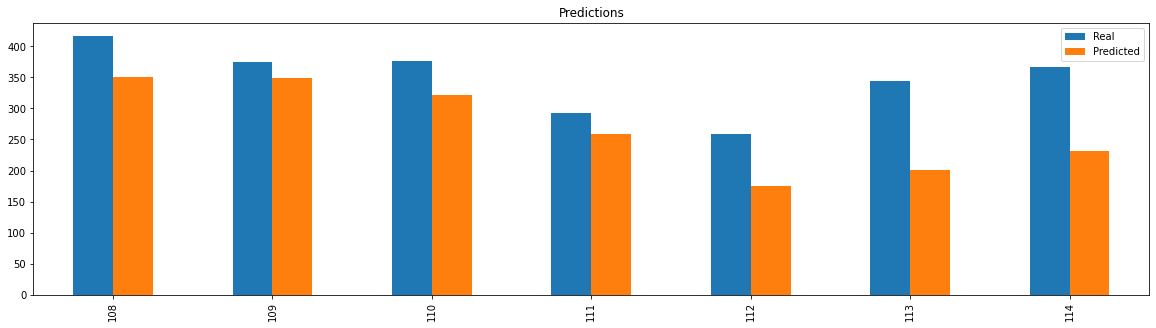

In [17]:
prediction_c = models_with_regularization_c['RidgePoly'].best_estimator_.predict(x_test_c)
barplot_prediction(prediction_c, y_test_c)

### Definição, treino e validação dos modelos para os novos óbitos

In [18]:
simple_models_o = calculate_simple_models()
models_with_regularization_o = calculate_models_with_regularization(x_train_o, y_train_o)

In [19]:
regularization_scores_o = dict(map(lambda x: (x[0], get_scores_models_with_regularization(x[1], x_test_o, y_test_o)), models_with_regularization_o.items()))

In [20]:
aux_dataset_o, y = data_split(dataset, 'obitos_novos')
simple_scores_o = dict(map(lambda x: (x[0], get_scores_simple_models(x[1], x_train_o, y_train_o, x_test_o, y_test_o, aux_dataset_o)), simple_models_o.items()))

Selected: 53 features from model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Column: confirmados_novos
Column: internados
Column: internados_uci
Column: lab
Column: vigilancia
Column: lab_lag_1
Column: lab_lag_2
Column: suspeitos_novos_lag_1
Column: suspeitos_novos_lag_3
Column: suspeitos_novos_lag_4
Column: suspeitos_novos_lag_5
Column: vigilancia_lag_1
Column: vigilancia_lag_2
Column: vigilancia_lag_4
Column: vigilancia_lag_5
Column: obitos_novos_lag_5
Column: obitos_novos_lag_8
Column: confirmados_novos_lag_2
Column: confirmados_novos_lag_3
Column: confirmados_novos_lag_6
Column: confirmados_novos_lag_7
Column: confirmados_novos_lag_8
Column: obitos_novos_trend_15
Column: obitos_novos_trend_16
Column: obitos_novos_trend_17
Column: obitos_novos_trend_18
Column: obitos_novos_trend_19
Column: obitos_novos_trend_20
Column: obitos_novos_trend_21
Column: obitos_novos_trend_22
Column: obitos_novos_trend_23
Column: obitos_novos_trend_24
Column: obitos_no

Ao contrário dos modelos para os novos casos confirmados, neste caso houve uma grande diminuição do número de features relevantes para o modelo. Vejamos, agora, os mais relevantes para o modelo com regularização com norma L2.

In [21]:
ridge_coefs = models_with_regularization_o['Ridge'].best_estimator_.coef_
x = [aux_dataset_o.columns[i] for i in list(range(len(ridge_coefs)))]
for i in get_sorted(x,ridge_coefs)[:20]:
    print("Atributo: " + i[0] + ", ", "coef: " + str(i[1]))

Atributo: obitos_novos_lag_2,  coef: 2.639632649541561
Atributo: obitos_novos_lag_4,  coef: 2.4546536565030013
Atributo: obitos_novos_lag_1,  coef: 2.4518650735098984
Atributo: lab,  coef: 2.1383605201685465
Atributo: obitos_novos_lag_5,  coef: 2.0367212585627463
Atributo: internados,  coef: 1.9417768319875173
Atributo: obitos_novos_lag_6,  coef: 1.908967183755123
Atributo: internados_uci,  coef: 1.874993871183933
Atributo: obitos_novos_lag_3,  coef: 1.7680824700404012
Atributo: suspeitos_novos_lag_4,  coef: 1.7202872185547495
Atributo: confirmados_novos_trend_24,  coef: 1.6743795111655457
Atributo: obitos_novos_lag_8,  coef: 1.6047891467665056
Atributo: lab_lag_1,  coef: 1.4196069876579536
Atributo: suspeitos_novos_lag_5,  coef: 1.3999449696003003
Atributo: confirmados_novos_lag_3,  coef: 1.386765839625094
Atributo: confirmados_novos_lag_5,  coef: 1.3751680373736639
Atributo: lab_lag_2,  coef: 1.3615138482938467
Atributo: obitos_novos_trend_17,  coef: 1.314174613254581
Atributo: obito

Mais uma vez o tempo perdido com o cálculo de lags e trends parece ter compensando, estando o modelo a usar cálculos deste tipo referentes tanto aos novos casos confirmados, como aos novos obitos, o que é normal, porque eles estão fortemente relacionados, sendo que atributos que afetem os casos confirmados também afetarão, em princípio, os obitos, aplicando-se também o contrário, devido a esta forte relação.

Quanto aos resultados obtidos o que falamos anteriormente aplica-se neste caso também. Existe uma grande quantidade de overfiting, sendo que não existe nenhum modelo que se destaque pela positiva, existe apenas a destacar o baixo erro no RidgePoly no treino e no teste, mas onde também existe um alto erro na validação. O modelo OLS é o que apresenta menos overfiting e parece ser o mais equilibrado, mas o erro no teste é o maior e, tendo em conta a ordem de grandeza, ainda é por alguma margem.

In [22]:
scores_o = pd.DataFrame(dict(simple_scores_o, **regularization_scores_o), index=['train', 'val', 'test'])
scores_o

,OLS,Lasso,Ridge,LassoPoly,RidgePoly
train,0.283012,2.118629,2.771372,2.088953,0.085591
val,19.528181,9.292154,8.908430,9.339147,7.727091
test,1.521186,2.224915,3.973592,1.871183,1.682214


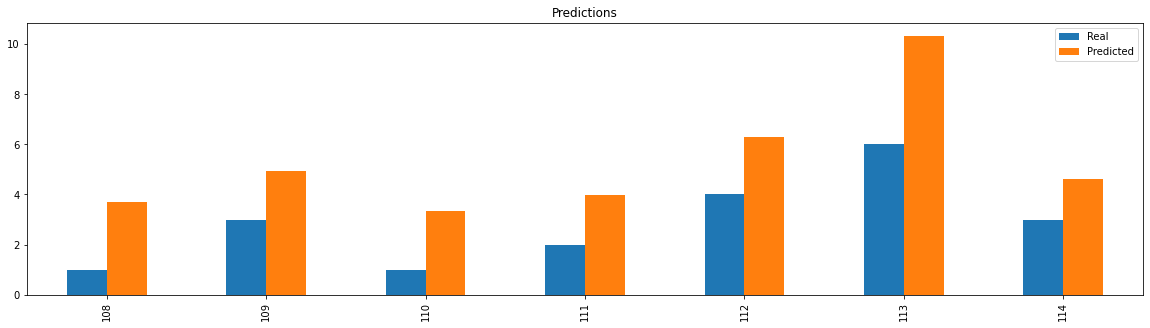

In [23]:
prediction_o = simple_models_o['OLS'].fit(x_train_o, y_train_o).predict(x_test_o)
barplot_prediction(prediction_o, y_test_o)

## Construção de um modelo com SVR

Para este modelo iremos utilizar randomizedSearchCV devido ao elevedo número de hiperparámetros e a junção do RFE neste processo, Infelizmente estamos limitados pelo RFE no que toca à utilização de tipos de kernels diferentes do lines, o que é limitante. Como não vamos usar gridSearch para estes seguintes modelos não vamos de todo chegar a uma solução ótima, porém podemos ter um modelo um pouco melhor do que sem otimização, sem sermos demasiado extensivos.

In [24]:
#Função auxiliar para usar RandomizedSearchCV com RFE
def singular_random_search(params, model, x_train, y_train, iters):
    tss = TimeSeriesSplit(n_splits=5).split(x_train)
    
    selector = RFE(estimator=model, step=1)
    estimator = RandomizedSearchCV(selector, param_distributions=params, n_iter = iters, cv=tss, scoring='neg_root_mean_squared_error', refit=True).fit(x_train, y_train).best_estimator_
    
    return estimator

### Definição, treino e validação do modelo SVR para os novos casos confirmados

In [25]:
svr_params = {'estimator__kernel' : ['linear'],
             'estimator__degree' : [2, 3, 4],
             'estimator__C' : [0.1, 1, 10, 20, 100, 250, 300, 500],
             'estimator__epsilon': [0.1, 1, 10, 100, 200, 220, 300],
             "estimator__gamma": ['auto', 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
           }

In [26]:
svr_c = SVR(cache_size=1000)
best_svr_model_c = singular_random_search(svr_params, svr_c, x_train_c, y_train_c, 100)

Modelo selecionado:

In [27]:
print(best_svr_model_c.estimator_)

SVR(C=250, cache_size=1000, coef0=0.0, degree=3, epsilon=10, gamma=1e-08,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


O modelo selecionou atributos semelhantes aos anteriores, porém selecionou mais. O resultado que apresentamos de seguida, mostra que este modelo no geral foi pior que os anteriores, tendo mais erro no teste e no treino, porém ganhou em termos de generalidade, tendo um erro na validação menor que os restantes modelos.

In [28]:
estimator = best_svr_model_c.estimator_
x_train_reduced_c = best_svr_model_c.transform(x_train_c)
x_test_reduced_c = best_svr_model_c.transform(x_test_c)
svr_scores_c = get_scores(estimator, x_train_reduced_c , y_train_c, x_test_reduced_c , y_test_c)
scores_c['SVR'] = svr_scores_c
scores_c

,OLS,Lasso,Ridge,LassoPoly,RidgePoly,SVR
train,148.527317,45.105386,42.670351,2.822345,8.979234,63.988778
val,228.731571,229.552069,217.500950,233.320803,220.587706,199.703699
test,87.211024,76.343416,80.725002,114.275068,88.971380,65.154221


Agora as previsões deste modelo para o conjunto de teste:

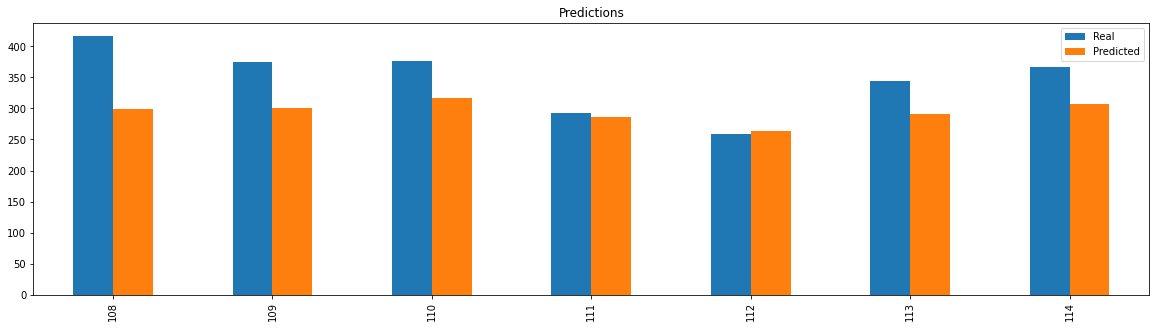

In [29]:
prediction_c = estimator.predict(x_test_reduced_c)
barplot_prediction(prediction_c, y_test_c)

### Definição, treino e validação do modelo SVR para os novos óbitos

In [30]:
svr_params = {'estimator__kernel' : ['linear'],
             'estimator__degree' : [2, 3, 4],
             'estimator__C' : [0.1, 1, 5, 7, 10, 20],
             'estimator__epsilon': [0.1, 0.5, 1, 5, 10],
             "estimator__gamma": ['auto', 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
           }

In [31]:
svr_o = SVR(cache_size=1000)
best_svr_model_o = singular_random_search(svr_params, svr_o, x_train_o, y_train_o, 100)

In [32]:
print(best_svr_model_o)

RFE(estimator=SVR(C=5, cache_size=1000, coef0=0.0, degree=4, epsilon=5,
                  gamma=1e-06, kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=None, step=1, verbose=0)


Assim como para os casos confirmados, o modelo dos óbitos com SVR não melhorou em relação aos outros modelos apresentados.

In [33]:
estimator = best_svr_model_o.estimator_
x_train_reduced_o = best_svr_model_o.transform(x_train_o)
x_test_reduced_o = best_svr_model_o.transform(x_test_o)
svr_scores_o = get_scores(estimator, x_train_reduced_o , y_train_o, x_test_reduced_o , y_test_o)
scores_o['SVR'] = svr_scores_o
scores_o

,OLS,Lasso,Ridge,LassoPoly,RidgePoly,SVR
train,0.283012,2.118629,2.771372,2.088953,0.085591,3.113824
val,19.528181,9.292154,8.908430,9.339147,7.727091,7.975965
test,1.521186,2.224915,3.973592,1.871183,1.682214,3.263754


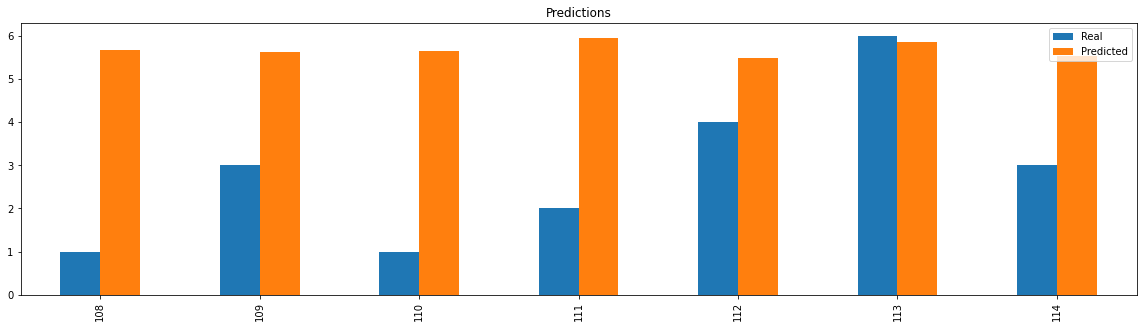

In [34]:
prediction_o = estimator.predict(x_test_reduced_o)
barplot_prediction(prediction_o, y_test_o)

# Random Forest Regressor

Tentemos agora por último um modelo utilizando Random Forest para a regressão. Este tipo de modelos, em teória, tem algumas vantagens inerentes aos conjuntos de modelos, como ser mais robusto, estável e ainda mais preciso, porque utilizamos vários modelos para a previsão. 

In [35]:
rand_f_params = {
    'estimator__n_estimators' : [10,50,100],
    'estimator__min_samples_leaf' : [2, 3, 5, 10],
    'estimator__min_samples_split' : [2, 3, 5, 10],
    "estimator__bootstrap": [True, False]
}

### Definição, treino e validação do modelo RFR para os novos casos confirmados

In [36]:
rand_f_c = RandomForestRegressor()
best_rand_f_model_c = singular_random_search(rand_f_params, rand_f_c, x_train_c, y_train_c, 25)

In [37]:
print(best_rand_f_model_c)

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=2,
                                    min_samples_split=5,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=10, n_jobs=None,
                                    oob_score=False, random_state=None,
                                    verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)


O modelo de RFR não apresentou melhores resultados do que os anteriores, como se pode verificiar na seguinte tabela, sendo até pior que o SVR, modelado anteriormente.

In [38]:
estimator = best_rand_f_model_c.estimator_
x_train_reduced_c = best_svr_model_c.transform(x_train_c)
x_test_reduced_c = best_svr_model_c.transform(x_test_c)
svr_scores_c = get_scores(estimator, x_train_reduced_c , y_train_c, x_test_reduced_c , y_test_c)
scores_c['RFR'] = svr_scores_c
scores_c

,OLS,Lasso,Ridge,LassoPoly,RidgePoly,SVR,RFR
train,148.527317,45.105386,42.670351,2.822345,8.979234,63.988778,66.037021
val,228.731571,229.552069,217.500950,233.320803,220.587706,199.703699,231.713156
test,87.211024,76.343416,80.725002,114.275068,88.971380,65.154221,42.226885


Previsão para o modelo calculado:

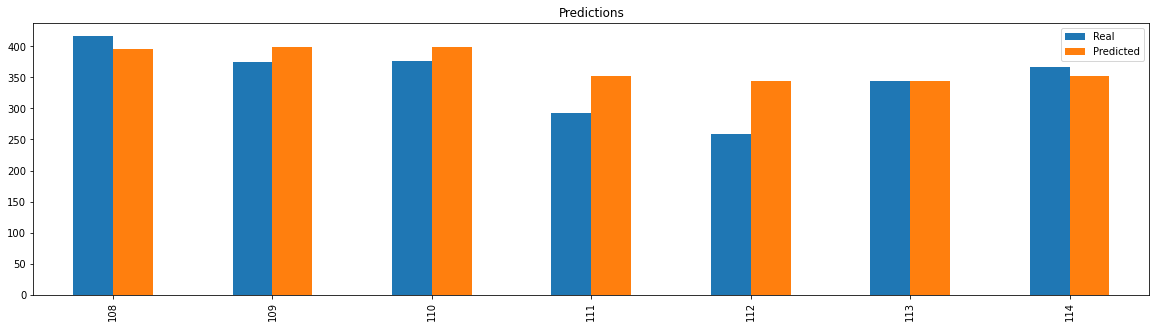

In [39]:
prediction_c = estimator.predict(x_test_reduced_c)
barplot_prediction(prediction_c, y_test_c)

### Definição, treino e validação do modelo RFR para os novos óbitos

In [40]:
rand_f_o = RandomForestRegressor()
best_rand_f_model_o = singular_random_search(rand_f_params, rand_f_o, x_train_o, y_train_o, 20)

In [41]:
print(best_rand_f_model_o)

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=2,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=None,
                                    verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)


In [42]:
estimator = best_rand_f_model_o.estimator_
x_train_reduced_o = best_svr_model_o.transform(x_train_o)
x_test_reduced_o = best_svr_model_o.transform(x_test_o)
svr_scores_o = get_scores(estimator, x_train_reduced_o , y_train_o, x_test_reduced_o , y_test_o)
scores_o['RFR'] = svr_scores_o
scores_o

,OLS,Lasso,Ridge,LassoPoly,RidgePoly,SVR,RFR
train,0.283012,2.118629,2.771372,2.088953,0.085591,3.113824,1.463047
val,19.528181,9.292154,8.908430,9.339147,7.727091,7.975965,8.433949
test,1.521186,2.224915,3.973592,1.871183,1.682214,3.263754,3.302090


Este modelo para os novos óbitos revelou-se um pouco interessante em relação aos restantes, visto que tem um erro no treino considerávelmente baixo, mas aparentar ser o que tem mais overfiting. Em comparação com o modelo formado para a previsão dos novos casos confirmados este modelo utiliza bastantes mais estimadores, sendo esta a diferença principal nos hiperparámetros dos modelos.

Fica, no entanto, o valor da previsão:

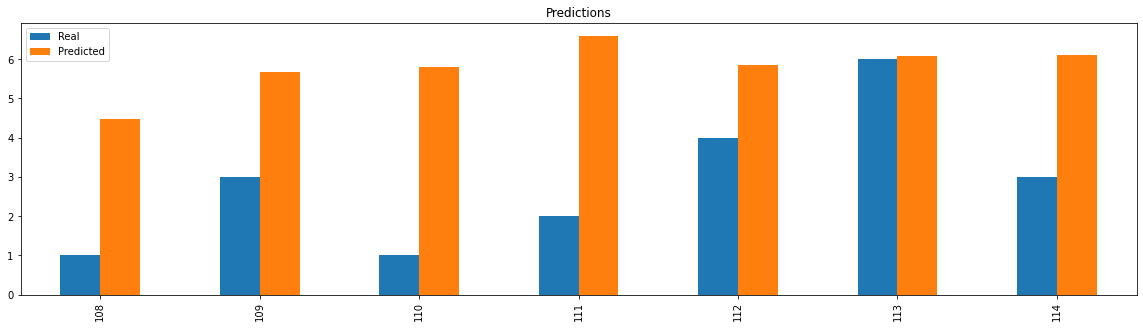

In [43]:
prediction_o = estimator.predict(x_test_reduced_o)
barplot_prediction(prediction_o, y_test_o)